In [2]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt


In [1]:
def resize_image(image):
    return image #cv2.resize(image, (300, 300), interpolation=cv2.INTER_AREA)

def apply_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def get_skin_mask_hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = (0, 20, 70)
    upper_skin = (20, 255, 255)
    return cv2.inRange(hsv_image, lower_skin, upper_skin)

def get_skin_mask_ycrcb(image):
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    lower_skin = (0, 135, 85)
    upper_skin = (255, 180, 135)
    return cv2.inRange(ycrcb_image, lower_skin, upper_skin)

def equalize_histogram(image):
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    channels = cv2.split(ycrcb_image)
    channels_list = list(channels)  # Convert tuple to list
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels_list[0] = clahe.apply(channels_list[0])
    return cv2.cvtColor(cv2.merge(channels_list), cv2.COLOR_YCrCb2BGR)  # Merge list back to tuple

def preprocess_image(image):
    resized_image = resize_image(image)
    equalized_image = equalize_histogram(resized_image)
    blurred_image = apply_gaussian_blur(equalized_image)
    
    hsv_mask = get_skin_mask_hsv(blurred_image)
    ycrcb_mask = get_skin_mask_ycrcb(blurred_image)
    
    skin_mask = cv2.bitwise_and(hsv_mask, ycrcb_mask)
    
    # Apply morphological operations to improve the skin mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    skin_mask = cv2.erode(skin_mask, kernel, iterations=2)
    skin_mask = cv2.dilate(skin_mask, kernel, iterations=2)

    # Apply a morphological closing operation to fill small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)
    
    # Apply the skin mask to the original image
    skin_segment = cv2.bitwise_and(blurred_image, blurred_image, mask=skin_mask)
    
    # Convert the skin segment to grayscale and apply thresholding
    gray_image = cv2.cvtColor(skin_segment, cv2.COLOR_BGR2GRAY)
    ret, thresh_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresh_image


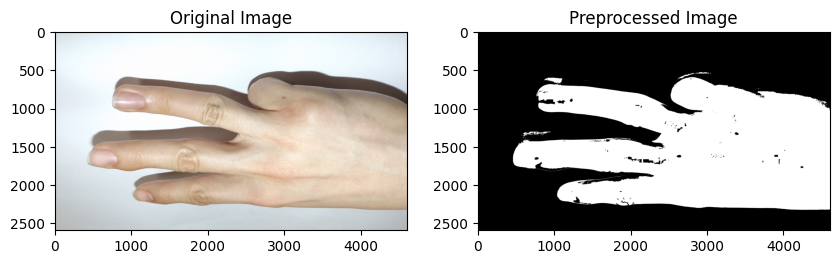

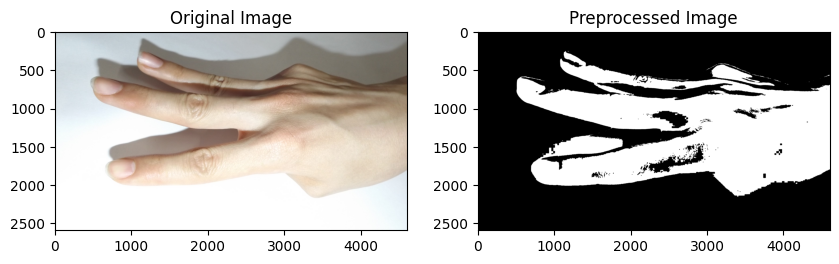

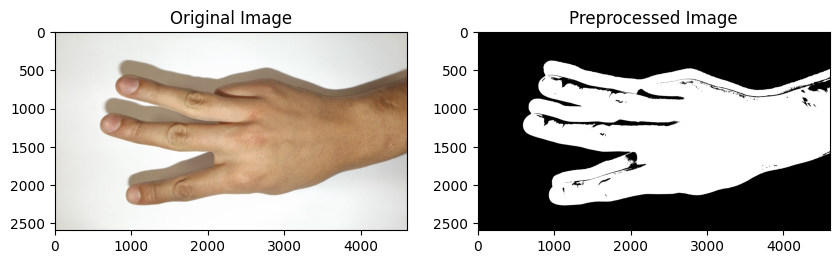

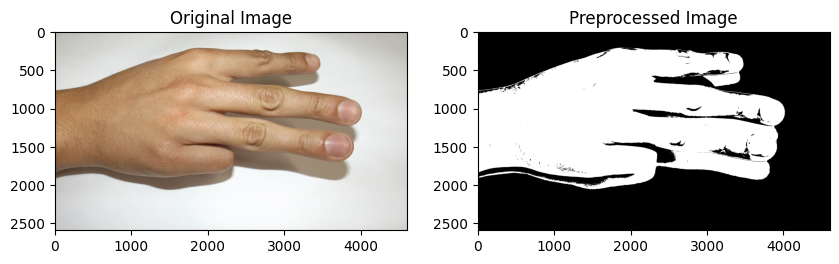

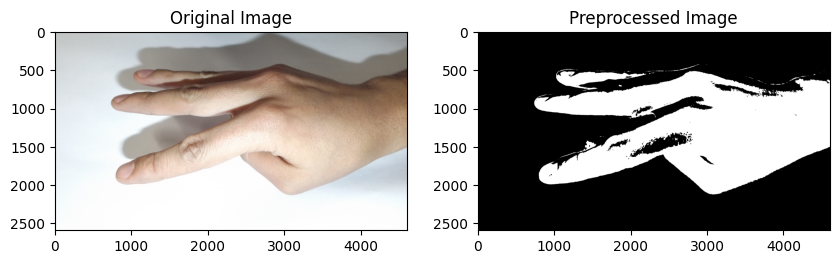

In [4]:
def test_stages(channel, index):
    # Load a sample images from the dataset

    sample_image_path = 'dataset/men/' + channel + '/' + channel + '_men (' + str(index) + ').JPG'
    img = cv2.imread(sample_image_path)

    # Preprocess the image
    preprocessed_image = preprocess_image(img)


    # Display the original, preprocessed images and features
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[1].imshow(preprocessed_image, cmap='gray')
    axes[1].set_title("Preprocessed Image")
    plt.show()

# Test the stages of the preprocessing pipeline by atterating over the channel with 5 indexes
for index in range(1, 6):
    test_stages(str(3), str(index))